{download}`Download this notebook <3_resistance_distance.ipynb>`

## The optimal low-resistance network
> **`gradnet` concepts demonstrated below**
> - Instantiating and configuring a `GradNet` model for network optimization
> - Implementing and passing custom loss functions to the optimizer
> - Training the network structure using `trainer.fit`
> - Converting the learned network to NetworkX format for further analysis
### Problem setup
Given a fixed wiring budget, how do you build a network with least resistance? That is we want the network with fixed total edge-weight which minimizes the Resistance Distance (i.e., Kirchhoff index). Resistance Distance is computed as the sum of all effective pair-wise resistances in the network

$$ \sum_{i<j} \Omega_{ij} = N\sum_{k=2}^N \frac{1}{\lambda_k}$$

Here $\lambda_k$ are the eigenvalues of the Laplacian matrix for the network ($L_{ij}=\sum_k A_{ik} - A_{ij}$). Note that $\lambda_0=0$, but it is skipped in the sum. 
Edge-weights $A_{ij}$ correspond to the conductences of the given edge, which is the inverse of resistance.

### GradNet optimization

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Updates:   0%|          | 0/100 [00:00<?, ?it/s]


  | Name | Type    | Params | Mode 
-----------------------------------------
0 | gn   | GradNet | 10.0 K | train
-----------------------------------------
10.0 K    Trainable params
0         Non-trainable params
10.0 K    Total params
0.040     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.


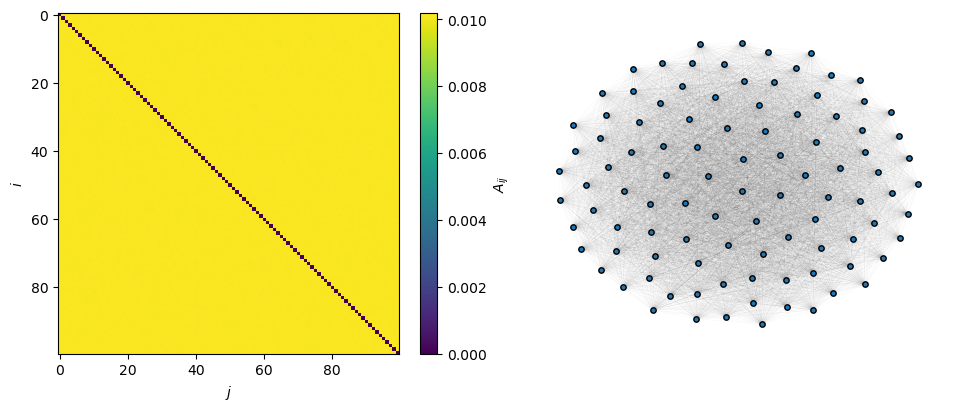

In [1]:
from gradnet import GradNet
from gradnet.trainer import fit
from gradnet.utils import plot_adjacency_heatmap, plot_graph
import torch
from matplotlib import pyplot as plt

N = 100
budget_per_node = 1.0

gn = GradNet(num_nodes=N, budget=budget_per_node*N, rand_init_weights=0.9)

def loss_fn(gn):
    A = gn()  # get the adjacency matrix
    L = torch.diag(A.sum(dim=1)) - A  # compute the graph Laplacian
    eigs = torch.linalg.eigvalsh(L)  # compute the eigenvalues
    r = torch.sum(1.0 / eigs[1:])  # compute the resistance distance
    # r is missing a constant factor N, but that doesn't change the optimization landscape
    return r

fit(gn=gn, loss_fn=loss_fn, num_updates=100, optim_kwargs={"lr": 0.1}, accelerator="cpu")

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
plot_adjacency_heatmap(gn, ax=ax0)
plot_graph(gn, ax=ax1)

We find that the uniform, conpletely connected graph is the optimal pattern for minimizing the resistance distance of the network.

### Restricting tunable edges to a grid

In [2]:
import numpy as np
import networkx as nx

rows = 30
cols = 30
N = rows * cols

def make_grid_mask(rows, cols):
    mask_nx = nx.grid_2d_graph(rows, cols)  # Build grid graph (nodes are (r, c) tuples)
    nodes = sorted(mask_nx.nodes())  # sort nodes
    return torch.tensor(nx.to_numpy_array(mask_nx, nodelist=nodes))

mask = make_grid_mask(rows, cols)

gn_grid = GradNet(num_nodes=N, budget=budget_per_node * N, mask=mask, rand_init_weights=0.9)
lightning_trainer, best_ckpt = fit(gn=gn_grid, loss_fn=loss_fn, num_updates=100, optim_kwargs={"lr": 0.01}, accelerator="cpu");

# lightning_trainer.plot_loss_vs_epoch()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Updates:   0%|          | 0/100 [00:00<?, ?it/s]


  | Name | Type    | Params | Mode 
-----------------------------------------
0 | gn   | GradNet | 810 K  | train
-----------------------------------------
810 K     Trainable params
0         Non-trainable params
810 K     Total params
3.240     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.


In [ ]:
from gradnet.utils import to_networkx


net = to_networkx(gn_grid)

def draw_grid_graph(net):
    """Draw a grid graph with edges colored by their weights."""
    edge_weights = np.array(list(nx.get_edge_attributes(net, 'weight').values()))
    pos = {r * cols + c: (c, -r) for r in range(rows) for c in range(cols)}

    fig, ax = plt.subplots(figsize=(8, 6))  # Create figure and axis

    # Draw graph on the same axis
    nx.draw_networkx_edges(net, pos=pos, ax=ax, edge_color=edge_weights, edge_cmap=plt.cm.viridis, width=3)
    nx.draw_networkx_nodes(net, pos=pos, ax=ax, nodelist=sorted(net.nodes()), node_color="k", node_size=10)
    ax.set_axis_off()

    # Add colorbar linked to edges
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
    sm.set_array(edge_weights)
    fig.colorbar(sm, ax=ax, label="conductance (edge weight)")

draw_grid_graph(net)
plt.show()